### Spam detection with Deep Learning

In [747]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_recall_curve, roc_curve,roc_auc_score

In [748]:
data_spam=pd.read_csv('spam.csv',encoding = "ISO-8859-1")
data_spam_original=data_spam.copy()

In [749]:
#Remove unncecessary columns and see the final dataframe
data_spam=data_spam[['v1','v2']]
data_spam=data_spam.rename({'v1':'Spam or Ham','v2':'SMS message'},axis=1)

In [750]:
data_spam.head()

,Spam or Ham,SMS message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [751]:
from sklearn.preprocessing import LabelBinarizer

In [752]:
lb=LabelBinarizer()
data_spam['Spam or Ham']=lb.fit_transform(data_spam['Spam or Ham'])

In [753]:
#See binarized classes - Spam or Ham
lb.classes_

array(['ham', 'spam'], dtype='<U4')

In [754]:
data_spam.shape

(5572, 2)

In [755]:
#Remove dots from the messages
data_spam['SMS message']=data_spam[['SMS message']].replace('\.','', regex=True)

In [756]:
#Check som random message
data_spam['SMS message'].iloc[np.random.randint(0,5571,1)]

3498    I hope you arnt pissed off but id would really...
Name: SMS message, dtype: object

In [757]:
#Libraries for Deep Learning
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.datasets import imdb
from tensorflow.keras import initializers

In [758]:
#Compute number of words in a message
n_words_in_message=[]
for i in range(len(data_spam)):
    n_words_in_message.append(len(data_spam.loc[i,'SMS message'].split()))
np.mean(n_words_in_message)

15.418700646087581

In [759]:
#Important parameters
max_features = 5000  # This is used in loading the data, picks the most common (max_features) words
maxlen = 25  # maximum length of a sequence - truncate after this
batch_size = 32

In [760]:
#check merging in one text file
text=['']
for i in range(len(data_spam)):
    text[0]+=' '+data_spam.loc[i,'SMS message']
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)[0]
print('Elements in sequences',len(sequences),' Words in total',len(text[0].split()))

Elements in sequences 82517  Words in total 85913


In [761]:
#check understanding
#list_1=tokenizer.texts_to_sequences(data_spam.loc[i,'SMS message'])
#list_2=[]
#list_1
#for i in range(len(list_1)):
#    try:
#        list_2.append(list_1[i][0])
#    except:
#        continue

In [762]:
X_data=[]
for i in range(len(data_spam)):
    convertion_to_int_1=tokenizer.texts_to_sequences(data_spam.loc[i,'SMS message'])#makes a list of lists
    convertion_to_int_2=[]
    for i in range(len(convertion_to_int_1)):
        try:
            convertion_to_int_2.append(convertion_to_int_1[i][0])
        except:
            continue
    X_data.append(convertion_to_int_2)
X_data=np.array(X_data,dtype='object')
len(X_data[5])

110

In [763]:
data_spam['Spam or Ham'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: Spam or Ham, dtype: float64

In [764]:
y_data=data_spam['Spam or Ham']

In [765]:
from sklearn.model_selection import StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=14)

In [766]:
#Stratified Train test split
train_ind, test_ind=next(sss.split(X_data, y_data))
X_train=X_data[train_ind]
X_test=X_data[test_ind]
y_train=y_data[train_ind]
y_test=y_data[test_ind]

In [767]:
y_train.value_counts(normalize=True)

0    0.865897
1    0.134103
Name: Spam or Ham, dtype: float64

In [768]:
#Engenieering the sequences
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (3900, 25)
x_test shape: (1672, 25)


In [920]:
#example of the sequence
X_train[123,:].shape

(25,)

In [770]:
X_test.shape

(1672, 25)

### Finally I can build a recurrent neural network

In [771]:
X_train.shape[1:]

(25,)

In [772]:
rnn_hidden_dim = 7
word_embedding_dim = 50
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=X_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [773]:
model_rnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 50)          250000    
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 7)                 406       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 8         
Total params: 250,414
Trainable params: 250,414
Non-trainable params: 0
_________________________________________________________________


In [1006]:
#Compiling the mode;
rmsprop = keras.optimizers.Adam(learning_rate = .005)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [1007]:
model_rnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=40,
          validation_data=(X_test, y_test),
             shuffle=True,
             verbose=0)

In [1008]:
scores=model_rnn.evaluate(X_test,y_test)
print('Performance of the model\n Validation set: Loss is {:.4f}, accuracy is {:.4f}'.format(scores[0],scores[1]) )

53/53 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9659
Performance of the model
 Validation set: Loss is 0.1274, accuracy is 0.9659


In [1009]:
#Prediction check
y_pred=model_rnn.predict(X_test)
len(y_pred)

1672

In [1011]:
y_pred_2=model_rnn.predict_classes(X_test)

In [1012]:
f1_score(y_test,y_pred_2)

0.8619854721549636

In [1013]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1448
           1       0.94      0.79      0.86       224

    accuracy                           0.97      1672
   macro avg       0.96      0.89      0.92      1672
weighted avg       0.97      0.97      0.96      1672



Label classes:
Class 0  :  ham
Class 1  :  spam


Text(0.5, 1.0, 'Confusion matrix of SPAM SMS detection with neural networks')

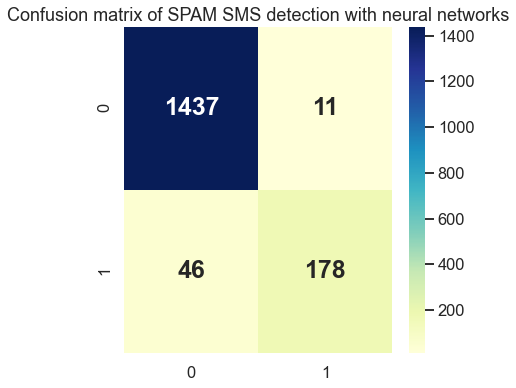

In [1020]:
#Determine finally the confusion matrix and plot it
conf_matrix=confusion_matrix(y_test,y_pred_2)
print('Label classes:')
for i in range(len(lb.classes_)):
    print('Class',i,' : ',lb.classes_[i])
_, ax = plt.subplots(figsize=(6,6))
ax=sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True, fmt='d',annot_kws={"size": 25, "weight": "bold"})
ax.set_title('Confusion matrix of SPAM SMS detection with neural networks',fontsize=18)

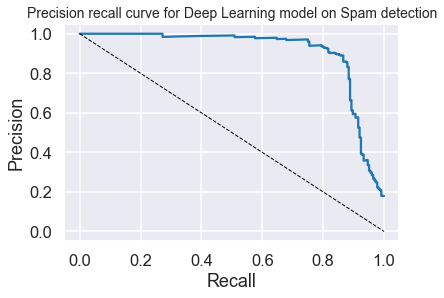

In [1015]:
precision, recall,_=precision_recall_curve(y_test,y_pred)
#Preciosion recall curve
sns.set_context('talk')
sns.set_style('dark')
plt.plot(recall,precision)
plt.plot([0, 1], [1, 0], 'k--', linewidth=1)  # roc curve for random model
plt.title('Precision recall curve for Deep Learning model on Spam detection',fontsize=14)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

[(-0.01, 1.01),
 (-0.01, 1.01),
 Text(0.5, 0, 'False positive rates'),
 Text(0, 0.5, 'True positive rates')]

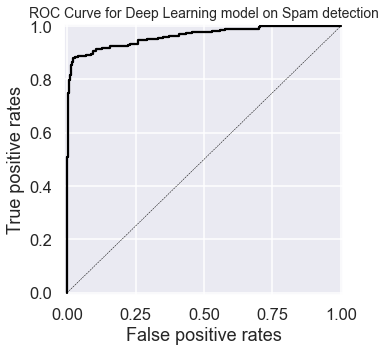

In [1016]:
#ROC AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, 'k-')
ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
ax.grid(True)
ax.set_title('ROC Curve for Deep Learning model on Spam detection', fontsize=14)
ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],xlabel='False positive rates',ylabel='True positive rates')

### Let's predict something

In [1017]:
# I put a similar spam email
#y_pred_2.shape
well_predicted_spam_message_indices=y_test[(y_pred_2.reshape(len(y_test))==1)&(y_test==1)].index
# I show some spam message
some_spam_message=str(data_spam.iloc[well_predicted_spam_message_indices[np.random.randint(0,100,1)],1].values[0])
#If I need to copy the message ----->
#some_spam_message='I have investment funds worth Twenty Seven Million Five Hundred Thousand United State Dollar ($27.500.000.00 ) and I need a trusted investment Manager/Partner because of my current refugee status'

In [1018]:
def convert_message_to_int_list(message):
    convertion_to_int_1=tokenizer.texts_to_sequences(message)#makes a list of lists
    convertion_to_int_2=[]
    for i in range(len(convertion_to_int_1)):
        try:
            convertion_to_int_2.append(convertion_to_int_1[i][0])
        except:
            continue
    convertion_to_int_2=np.array(convertion_to_int_2)
    return convertion_to_int_2
some_spam_message2=convert_message_to_int_list(some_spam_message)
some_spam_message2=some_spam_message2.reshape(1,len(some_spam_message2))
some_spam_message2=sequence.pad_sequences(some_spam_message2,maxlen=maxlen)

In [1019]:
print(some_spam_message)
print('\nMy spam filter says it is '+lb.classes_[model_rnn.predict_classes(some_spam_message2)[0,0]])

Ever thought about living a good life with a perfect partner? Just txt back NAME and AGE to join the mobile community (100p/SMS)

My spam filter says it is spam


C:\Users\AlexB\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
